# Lab 4 session Panel Data with fixed effects and Difference-in-Differences
The outline of this session is as follows:
1. Exploring fixed effects regression model for panel data
2. Identifying the treatment effect using the difference-in-difference analysis

In [2]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel

## 1. Fixed Effects Regression for Panel Data
Panel data, sometimes called longitudinal data, refers to data for n different entities observed at T different time periods. Example of units are firms, individuals, countries...

In this example, we will estimate the effect of marriage on income. The dataset contains those 2 variables, `married` and `lwage`, on multiple individuals (`nr`) for multiple years. Notice that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [3]:
data = wage_panel.load()
data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


In [11]:
data.set_index(["nr", "year"]) # reformat the data by units (entities) and by time

black  exper  hisp  hours  married  educ  union     lwage   
nr    year                                                              
13    1980      0      1     0   2672        0    14      0  1.197540  \
      1981      0      2     0   2320        0    14      1  1.853060   
      1982      0      3     0   2940        0    14      0  1.344462   
      1983      0      4     0   2960        0    14      0  1.433213   
      1984      0      5     0   3071        0    14      0  1.568125   
...           ...    ...   ...    ...      ...   ...    ...       ...   
12548 1983      0      8     0   2080        1     9      0  1.591879   
      1984      0      9     0   2080        1     9      1  1.212543   
      1985      0     10     0   2080        1     9      0  1.765962   
      1986      0     11     0   2080        1     9      1  1.745894   
      1987      0     12     0   3380        1     9      1  1.466543   

            expersq  occupation  
nr    year                       
13    1980        1           9  
      1981        4           9  
      1982        9           9  
      1983       16           9  
      1984       25           5  
...             ...         ...  
12548 1983       64           5  
      1984       81           5  
      1985      100           5  
      1986      121           5  
      1987      144           5  

[4360 rows x 10 columns]

The advantage of introducing fixed effects is to control for a set of unobserved characteristics at the group level. When estimating the regression model with fixed effects, all the variables that are constant within the group, including not only unobserved characteristics but other constant observed variables, will be wiped out in the demeaning process. Therefore, we cannot identify the effect of the variable that do not exhibit any within-group variation.

To check which variables are those, we can group our data by individual and get the sum of the standard deviations. If it is zero, it means the variable isn't changing across time for any of the individuals.

In [4]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

For our data, we need to remove ethnicity dummies, black and hisp, since they are constant for the individual. Also, we need to remove education. We will also not use occupation, since this is probably mediating the effect of marriage on wage (it could be that single men are able to take more time demanding positions).

In [8]:
Y = 'lwage' # name of the dependent variable Y
T = 'married' # name of the treatment variable T
X = [T, 'expersq', 'union', 'hours'] # names of a set of independent variables, X

print(data[X].head(5))

   married  expersq  union  hours
0        0        1      0   2672
1        0        4      1   2320
2        0        9      0   2940
3        0       16      0   2960
4        0       25      0   3071


### 1.1 Entity Fixed Effects
Having selected the features we will use, it's time to estimate this model with entity fixed effects.\\
$y_{i,t} = /beta X_{it} + /alpha_i + /epsilon_{i,t}$\\
One detail here is that for fixed effect models, the standard errors need to be clustered. *We can use the library `linearmodels` and set the argument `cluster_entity` to True.*

In [16]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ married+expersq+union+hours+EntityEffects",
                            data=data.set_index(["nr", "year"])) # data needs to have a panel data structure. In most cases, data should be a multi-index DataFrame where the level 0 index contains the entities and the level 1 contains the time.

result = mod.fit(cov_type='clustered', cluster_entity=True)
print(result.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.1147     0.0220     5.2213     0.0000      0.0716      0.1577
expersq        0.0040     0.0002     16.552     0.0000      0.0035      0.0044
union          0.0784     0.0236     3.3225     0.0009      0.0322      0.1247
hours       -8.46e-05   2.22e-05    -3.8105     0.0001     -0.0001  -4.107e-05


If we believe that entity fixed effect eliminates the all omitted variable bias, this model is telling us that marriage increases a man’s wage by 11%. This result is very significant.

### 1.2 Time Fixed Effects
Just like we did a fixed effect for the individual level, we could design a fixed effect for the time level. Adding a time fixed effect would control for variables that are fixed for each time period, but that might change across time. One example of such a variable is inflation. Prices and salary tend to go up with time, but the inflation on each time period is the same for all entities.

To give a more concrete example, suppose that marriage is increasing with time. If the wage and marriage proportion also changes with time, we would have time as a confounder. Since inflation also makes salary increase with time, some of the positive association we see between marriage and wage would be simply because both are increasing with time. To correct for that, we can add a dummy variable for each time period. In `linear models`, this is as simple as adding `TimeEffects` to our formula and setting the `cluster_time` to true.

In [17]:
mod = PanelOLS.from_formula("lwage ~ married+expersq+union+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
print(result.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0476     0.0177     2.6906     0.0072      0.0129      0.0823
expersq       -0.0062     0.0008    -8.1479     0.0000     -0.0077     -0.0047
union          0.0727     0.0228     3.1858     0.0015      0.0279      0.1174
hours         -0.0001  3.546e-05    -3.8258     0.0001     -0.0002  -6.614e-05


In this new model, the effect of marriage on wage decreased significantly from 0.1147 to 0.0476. Still, this result is significant at a 99% level, so man could still expect an increase in earnings from marriage.

### 1.3 Visualizing Fixed Effects
Suppose you work for a big tech company and you want to estimate the impact of a billboard marketing campaign on in-app purchase. When you look at data from the past, you see that the marketing department tends to spend more to place billboards on cities where the purchase level is lower. This makes sense right? They wouldn’t need to do lots of advertisement if sales were skyrocketing. If you run a regression model on this data, it looks like higher cost in marketing leads to less in-app purchase, but only because marketing investments is biased towards low spending regions.

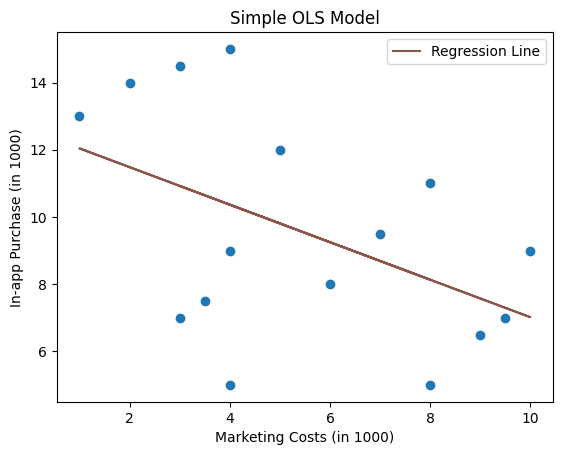

In [18]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
}) # create a panel

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

Knowing a lot about causal inference, you decide to run a fixed effect model, adding the city’s indicator as a dummy variable to your model. The fixed effect model controls for city specific characteristics that are constant in time, so if a city is less open to your product, it will capture that. When you run that model, you can finally see that more marketing costs leads to higher in-app purchase.

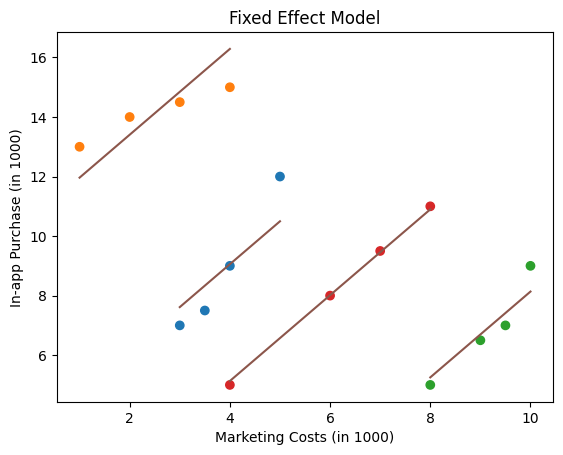

In [19]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit() # using least square dummy variable for illustration

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Take a minute to appreciate what the image above is telling you about what fixed effect is doing. Notice that fixed effect is fitting one regression line per city. Also notice that the lines are parallel. The slope of the line is the effect of marketing costs on in-app purchase. So the fixed effect is assuming that the causal effect is constants across all entities, which are cities in this case. This can be a weakness or an advantage, depending on how you see it. It is a weakness if you are interested in finding the causal effect per city. Since the FE model assumes this effect is constant across entities, you won’t find any difference in the causal effect. However, if you want to find the overall impact of marketing on in-app purchase, the panel structure of the data is a very useful leverage that fixed effects can explore.

## 2 Difference-in-Difference
We are studying the question that did elimination of copayment increase visits to the physician?

In 2010 Norway eliminated copayment for visiting a physicial for everybody below 16 years old. Before 2010 the thrshold for copayment was 12. This means that those between 12 and 16 now could go to the doctor with no copayment. The question is then: Did the reform increase their number of visits and if so, by how much? In this paper we focus mainly on one method of answering the question: The difference-in-difference method. The intuition is to compare the trend for the group that is affected with a groups that has a common trend before the reform, but who is not affected by the reform.

![J7P3p.png](https://i.stack.imgur.com/J7P3p.png)

In [25]:
# Import tools
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

# Read data
df = pd.read_csv('https://raw.githubusercontent.com/HeyyNing/labs/main/lab4/femaleVisitsToPhysician.csv')
df.head()

,Unnamed: 0,year,age,sex,consultations,population,perCapita
0,4,2006,1,f,67194.0,28221.0,2.380993
1,7,2006,2,f,49802.0,28361.0,1.756003
2,10,2006,3,f,42741.0,27899.0,1.531990
3,13,2006,4,f,36555.0,28420.0,1.286242
4,16,2006,5,f,33319.0,29479.0,1.130262


In [26]:
# Rename the columns
df.rename(columns={'consultations':'visits'}, inplace=True)
df.head()

,Unnamed: 0,year,age,sex,visits,population,perCapita
0,4,2006,1,f,67194.0,28221.0,2.380993
1,7,2006,2,f,49802.0,28361.0,1.756003
2,10,2006,3,f,42741.0,27899.0,1.531990
3,13,2006,4,f,36555.0,28420.0,1.286242
4,16,2006,5,f,33319.0,29479.0,1.130262


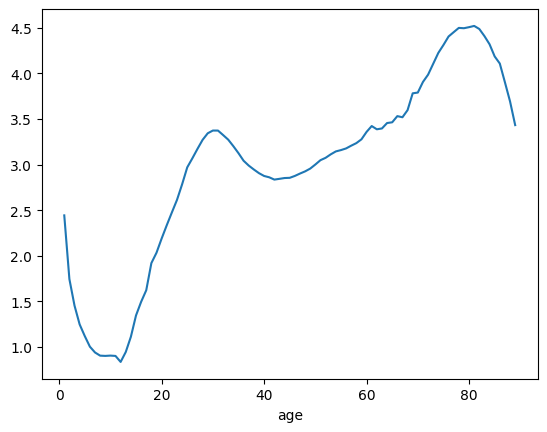

In [27]:
# find average number of visits in different age groups
df.groupby('age')['perCapita'].mean().plot();

In [28]:
# see if there is a time trend for 14 year olds
# create a dataframe with only 14 year olds
df14 = df.query('age==14')
df14

,Unnamed: 0,year,age,sex,visits,population,perCapita
13,43,2006,14,f,29129.0,30927.0,0.941863
102,399,2007,14,f,29563.0,30464.0,0.970424
191,752,2008,14,f,29848.0,30578.0,0.976127
280,1100,2009,14,f,31140.0,30755.0,1.012518
369,1439,2010,14,f,36296.0,30983.0,1.171481
458,1774,2011,14,f,39799.0,31522.0,1.262579
547,2087,2012,14,f,38880.0,31080.0,1.250965
636,2369,2013,14,f,39609.0,30559.0,1.296148


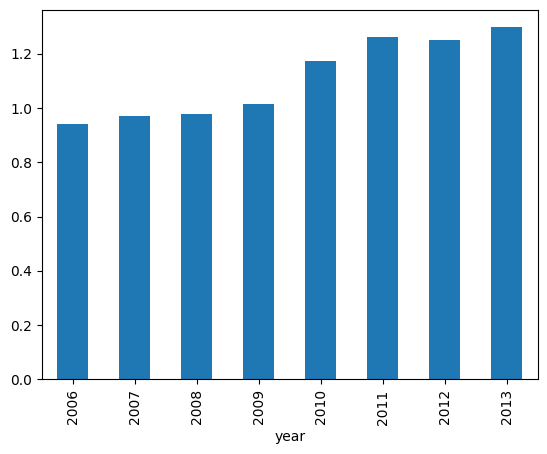

In [29]:
# set year as index to get it on the x-scale
df14.set_index('year').perCapita.plot.bar();

In [30]:
# Now: Want to create a graph that compared the change over time for 14 and 25 year olds; age=25 as the control group
df2 = df.query('age==14 or age==25')

# focus on only those three variables
df2 = df2[['year', 'age', 'perCapita']]

df2.head()

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127


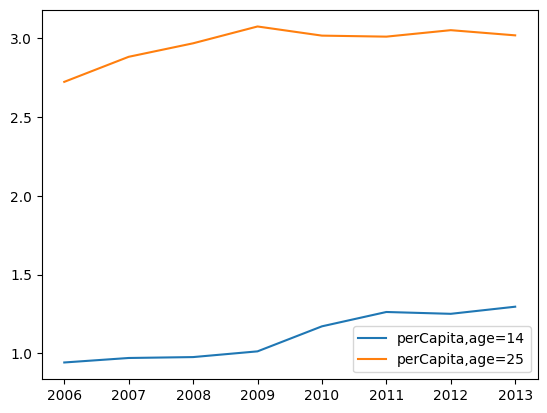

In [33]:
# plot a figure to show the time trend for two different groups

plt.plot(df2.query('age==14')['year'],df2.query('age==14')['perCapita'],label = 'perCapita,age=14')
plt.plot(df2.query('age==25')['year'],df2.query('age==25')['perCapita'],label = 'perCapita,age=25')
plt.legend()

In [34]:
# Now: Shape the dataset so we can run a difference-in-difference
# Compare 14 year olds to, for instance, 25 year olds (You should probably use a control group that is closer in age!)

df14and25 = df2.set_index(['year', 'age']).unstack('age')
df14and25

perCapita          
age         14        25
year                    
2006  0.941863  2.724488
2007  0.970424  2.883638
2008  0.976127  2.969386
2009  1.012518  3.076277
2010  1.171481  3.018165
2011  1.262579  3.011706
2012  1.250965  3.052795
2013  1.296148  3.019887

In [36]:
# create a variable that represent the reform (0 before the reform, 1 after)
df14and25['copay'] = 0
df14and25['copay'] = df14and25.copay.where(df14and25.index<2010, 1) #Replace values with 1 where the condition is False.
df14and25

perCapita           copay
age         14        25      
year                          
2006  0.941863  2.724488     0
2007  0.970424  2.883638     0
2008  0.976127  2.969386     0
2009  1.012518  3.076277     0
2010  1.171481  3.018165     1
2011  1.262579  3.011706     1
2012  1.250965  3.052795     1
2013  1.296148  3.019887     1

In [37]:
# compare groups means
result = df14and25.groupby('copay').mean()
result

perCapita          
age          14        25
copay                    
0      0.975233  2.913447
1      1.245293  3.025638

In [38]:
result.columns = ['age_14', 'age_25'] # rename the columns
result

,age_14,age_25
copay,,
0,0.975233,2.913447
1,1.245293,3.025638


In [39]:
result['age_25'] - result['age_14'] # cross-sectional differences

copay
0    1.938214
1    1.780345
dtype: float64

In [40]:
(result['age_25'] - result['age_14']).diff() # time difference

copay
0         NaN
1   -0.157869
dtype: float64

In [41]:
# Now lets run a diff-in-diff regression
df2

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127
202,2008,25,2.969386
280,2009,14,1.012518
291,2009,25,3.076277
369,2010,14,1.171481
380,2010,25,3.018165


In [42]:
# create new variable
df2['copay']=0
df2['copay']=df2['copay'].where(df2.year<2010,1)
df2

,year,age,perCapita,copay
13,2006,14,0.941863,0
24,2006,25,2.724488,0
102,2007,14,0.970424,0
113,2007,25,2.883638,0
191,2008,14,0.976127,0
202,2008,25,2.969386,0
280,2009,14,1.012518,0
291,2009,25,3.076277,0
369,2010,14,1.171481,1
380,2010,25,3.018165,1


In [43]:
df2['age_14'] = np.where(df2.age==14,1,0)
df2

,year,age,perCapita,copay,age_14
13,2006,14,0.941863,0,1
24,2006,25,2.724488,0,0
102,2007,14,0.970424,0,1
113,2007,25,2.883638,0,0
191,2008,14,0.976127,0,1
202,2008,25,2.969386,0,0
280,2009,14,1.012518,0,1
291,2009,25,3.076277,0,0
369,2010,14,1.171481,1,1
380,2010,25,3.018165,1,0


Estimating the difference in difference equation:
outcome = treated dummy + after intervention + affected by * after dummy (+ other_variables)

visits = being_14 + after2010 + being_14 * after2010

In [44]:
model = 'perCapita ~ age_14 + copay + copay * age_14 + year'
mod = smf.ols(formula=model, data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              perCapita   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     987.2
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           5.65e-14
Time:                        14:26:03   Log-Likelihood:                 25.410
No. Observations:                  16   AIC:                            -40.82
Df Residuals:                      11   BIC:                            -36.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -85.7891     26.764     -3.205   

/Users/zhang_ning/anaconda3/envs/pythonProject/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


The coefficient of copay:age_14 is significantly different from 0 at the 5 percent level. For the treatment group (age=14), the number of visits increases by 0.1579 after the reform.